## Importing the Data

In [1]:
# Constants
DATASET_DIR = './data/'
GLOVE_DIR = './glove.6B/'
SAVE_DIR = './'

import os
import pandas as pd

X = pd.read_csv(os.path.join(DATASET_DIR, 'training_set_rel3.tsv'), sep='\t', encoding='ISO-8859-1')
y = X['domain1_score']
X = X.dropna(axis=1)
X = X.drop(columns=['rater1_domain1', 'rater2_domain1'])

In [2]:
X.head()

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8


Minimum and Maximum Scores for each essay set.

In [3]:
minimum_scores = [-1, 2, 1, 0, 0, 0, 0, 0, 0]
maximum_scores = [-1, 12, 6, 3, 3, 4, 4, 30, 60]

## Preprocessing the Data

We will preprocess all essays and convert them to feature vectors so that they can be fed into the RNN.

These are all helper functions used to clean the essays.

In [4]:
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec

def essay_to_wordlist(essay_v, remove_stopwords):
    """Remove the tagged labels and word tokenize the sentence."""
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return (words)

def essay_to_sentences(essay_v, remove_stopwords):
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

def makeFeatureVec(words, model, num_features):
    """Make Feature Vector from the words list of an Essay."""
    featureVec = np.zeros((num_features,),dtype="float32")
    num_words = 0.
    index_to_key_set = set(model.wv.index_to_key)
    for word in words:
        if word in index_to_key_set:
            num_words += 1
            featureVec = np.add(featureVec,model.wv[word])
    featureVec = np.divide(featureVec,num_words)
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    """Main function to generate the word vectors for word2vec model."""
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs

## Defining the model 

Here we define a 2-Layer LSTM Model. 

Note that instead of using sigmoid activation in the output layer we will use
Relu since we are not normalising training labels.

In [5]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K

def get_model():
    """Define the model."""
    model = Sequential()
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    return model

# Call the function and print the summary
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 300)            721200    
                                                                 
 lstm_1 (LSTM)               (None, 64)                93440     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________


## Training Phase

Now we train the model on the dataset.

We will use 5-Fold Cross Validation and measure the Quadratic Weighted Kappa for each fold.
We will then calculate Average Kappa for all the folds.

In [6]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score

cv = KFold(5, shuffle=True)
results = []
y_pred_list = []

count = 1
for traincv, testcv in cv.split(X):
    print("\n--------Fold {}--------\n".format(count))
    X_test, X_train, y_test, y_train = X.iloc[testcv], X.iloc[traincv], y.iloc[testcv], y.iloc[traincv]

    train_essays = X_train['essay']
    test_essays = X_test['essay']

    sentences = []

    for essay in train_essays:
            # Obtaining all sentences from the training essays.
            sentences += essay_to_sentences(essay, remove_stopwords = True)

    # Initializing variables for word2vec model.
    num_features = 300
    min_word_count = 40
    num_workers = 4
    context = 10
    downsampling = 1e-3

    print("Training Word2Vec Model...")
    model = Word2Vec(sentences, workers=num_workers, vector_size=num_features, min_count = min_word_count, window = context, sample = downsampling)

    model.init_sims(replace=True)
    model.wv.save_word2vec_format('word2vecmodel.bin', binary=True)

    clean_train_essays = []

    # Generate training and testing data word vectors.
    for essay_v in train_essays:
        clean_train_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))
    trainDataVecs = getAvgFeatureVecs(clean_train_essays, model, num_features)

    clean_test_essays = []
    for essay_v in test_essays:
        clean_test_essays.append(essay_to_wordlist( essay_v, remove_stopwords=True ))
    testDataVecs = getAvgFeatureVecs( clean_test_essays, model, num_features )

    trainDataVecs = np.array(trainDataVecs)
    testDataVecs = np.array(testDataVecs)
    # Reshaping train and test vectors to 3 dimensions. (1 represnts one timestep)
    trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))

    lstm_model = get_model()
    lstm_model.fit(trainDataVecs, y_train, batch_size=64, epochs=50)
    #lstm_model.load_weights('./model_weights/final_lstm.h5')
    y_pred = lstm_model.predict(testDataVecs)

    # Save any one of the 8 models.
    if count == 5:
         lstm_model.save('./model_weights/final_lstm.h5')

    # Round y_pred to the nearest integer.
    y_pred = np.around(y_pred)

    # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
    result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
    print("Kappa Score: {}".format(result))
    results.append(result)

    count += 1



--------Fold 1--------

Training Word2Vec Model...


C:\Users\Harish Nilare\AppData\Local\Temp\ipykernel_15608\3536359127.py:33: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


Epoch 1/50
163/163 [==============================] - 6s 15ms/step - loss: 66.1828 - mae: 4.4399
Epoch 2/50
163/163 [==============================] - 2s 15ms/step - loss: 40.6855 - mae: 3.6623
Epoch 3/50
163/163 [==============================] - 3s 18ms/step - loss: 34.1474 - mae: 3.5287
Epoch 4/50
163/163 [==============================] - 3s 17ms/step - loss: 31.4153 - mae: 3.4568
Epoch 5/50
163/163 [==============================] - 3s 18ms/step - loss: 29.4355 - mae: 3.2461
Epoch 6/50
163/163 [==============================] - 3s 16ms/step - loss: 27.0211 - mae: 3.0574
Epoch 7/50
163/163 [==============================] - 3s 16ms/step - loss: 23.7213 - mae: 2.8220
Epoch 8/50
163/163 [==============================] - 3s 17ms/step - loss: 20.4645 - mae: 2.5923
Epoch 9/50
163/163 [==============================] - 3s 17ms/step - loss: 18.1438 - mae: 2.4204
Epoch 10/50
163/163 [==============================] - 2s 15ms/step - loss: 17.1660 - mae: 2.3649
Epoch 11/50
163/163 [========

C:\Users\Harish Nilare\AppData\Local\Temp\ipykernel_15608\3536359127.py:33: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


Epoch 1/50
163/163 [==============================] - 6s 15ms/step - loss: 65.4681 - mae: 4.4584
Epoch 2/50
163/163 [==============================] - 3s 16ms/step - loss: 40.6767 - mae: 3.6645
Epoch 3/50
163/163 [==============================] - 3s 17ms/step - loss: 34.0297 - mae: 3.5609
Epoch 4/50
163/163 [==============================] - 3s 17ms/step - loss: 30.9466 - mae: 3.4844
Epoch 5/50
163/163 [==============================] - 3s 16ms/step - loss: 28.8007 - mae: 3.2922
Epoch 6/50
163/163 [==============================] - 2s 15ms/step - loss: 27.1684 - mae: 3.1339
Epoch 7/50
163/163 [==============================] - 2s 14ms/step - loss: 25.0742 - mae: 2.9190
Epoch 8/50
163/163 [==============================] - 2s 14ms/step - loss: 21.7904 - mae: 2.7009
Epoch 9/50
163/163 [==============================] - 2s 15ms/step - loss: 19.3428 - mae: 2.5281
Epoch 10/50
163/163 [==============================] - 3s 15ms/step - loss: 17.7594 - mae: 2.4056
Epoch 11/50
163/163 [========

C:\Users\Harish Nilare\AppData\Local\Temp\ipykernel_15608\3536359127.py:33: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


Epoch 1/50
163/163 [==============================] - 6s 15ms/step - loss: 63.6550 - mae: 4.3962
Epoch 2/50
163/163 [==============================] - 2s 15ms/step - loss: 39.4742 - mae: 3.6279
Epoch 3/50
163/163 [==============================] - 2s 15ms/step - loss: 33.8614 - mae: 3.4872
Epoch 4/50
163/163 [==============================] - 2s 15ms/step - loss: 30.5598 - mae: 3.3749
Epoch 5/50
163/163 [==============================] - 2s 15ms/step - loss: 29.4686 - mae: 3.2634
Epoch 6/50
163/163 [==============================] - 2s 15ms/step - loss: 27.9004 - mae: 3.0972
Epoch 7/50
163/163 [==============================] - 2s 15ms/step - loss: 24.8334 - mae: 2.8890
Epoch 8/50
163/163 [==============================] - 3s 16ms/step - loss: 20.7533 - mae: 2.6613
Epoch 9/50
163/163 [==============================] - 2s 15ms/step - loss: 18.5004 - mae: 2.4942
Epoch 10/50
163/163 [==============================] - 2s 15ms/step - loss: 16.9468 - mae: 2.3726
Epoch 11/50
163/163 [========

C:\Users\Harish Nilare\AppData\Local\Temp\ipykernel_15608\3536359127.py:33: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


Epoch 1/50
163/163 [==============================] - 7s 19ms/step - loss: 68.3738 - mae: 4.4885
Epoch 2/50
163/163 [==============================] - 3s 20ms/step - loss: 41.4707 - mae: 3.6588
Epoch 3/50
163/163 [==============================] - 3s 19ms/step - loss: 34.6401 - mae: 3.5383
Epoch 4/50
163/163 [==============================] - 3s 19ms/step - loss: 31.8201 - mae: 3.4598
Epoch 5/50
163/163 [==============================] - 3s 20ms/step - loss: 29.1298 - mae: 3.2805
Epoch 6/50
163/163 [==============================] - 3s 20ms/step - loss: 27.4913 - mae: 3.1030
Epoch 7/50
163/163 [==============================] - 3s 19ms/step - loss: 24.4906 - mae: 2.8745
Epoch 8/50
163/163 [==============================] - 3s 19ms/step - loss: 20.2573 - mae: 2.6472
Epoch 9/50
163/163 [==============================] - 3s 19ms/step - loss: 18.7023 - mae: 2.5092
Epoch 10/50
163/163 [==============================] - 3s 19ms/step - loss: 17.3146 - mae: 2.3844
Epoch 11/50
163/163 [========

C:\Users\Harish Nilare\AppData\Local\Temp\ipykernel_15608\3536359127.py:33: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


Epoch 1/50
163/163 [==============================] - 7s 22ms/step - loss: 65.3206 - mae: 4.4374
Epoch 2/50
163/163 [==============================] - 4s 22ms/step - loss: 39.3562 - mae: 3.5813
Epoch 3/50
163/163 [==============================] - 4s 22ms/step - loss: 32.4453 - mae: 3.4433
Epoch 4/50
163/163 [==============================] - 4s 22ms/step - loss: 30.2950 - mae: 3.3785
Epoch 5/50
163/163 [==============================] - 4s 22ms/step - loss: 28.0509 - mae: 3.1731
Epoch 6/50
163/163 [==============================] - 4s 22ms/step - loss: 25.8540 - mae: 2.9768
Epoch 7/50
163/163 [==============================] - 4s 22ms/step - loss: 23.4847 - mae: 2.7968
Epoch 8/50
163/163 [==============================] - 4s 22ms/step - loss: 20.7715 - mae: 2.5944
Epoch 9/50
163/163 [==============================] - 4s 21ms/step - loss: 18.7770 - mae: 2.4589
Epoch 10/50
163/163 [==============================] - 3s 21ms/step - loss: 16.4448 - mae: 2.3124
Epoch 11/50
163/163 [========

In [7]:
print("Average Kappa score after a 5-fold cross validation: ",np.around(np.array(results).mean(),decimals=4))

Average Kappa score after a 5-fold cross validation:  0.9596


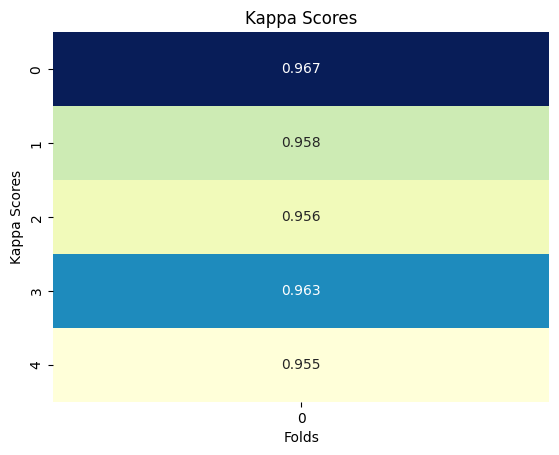

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# create a matrix of Kappa scores
kappa_matrix = np.array(results).reshape(5,1)

# create a heatmap
ax = sns.heatmap(kappa_matrix, cmap="YlGnBu", annot=True, fmt=".3f", cbar=False)

# set the title and axis labels
ax.set_title('Kappa Scores')
ax.set_xlabel('Folds')
ax.set_ylabel('Kappa Scores')

plt.show()


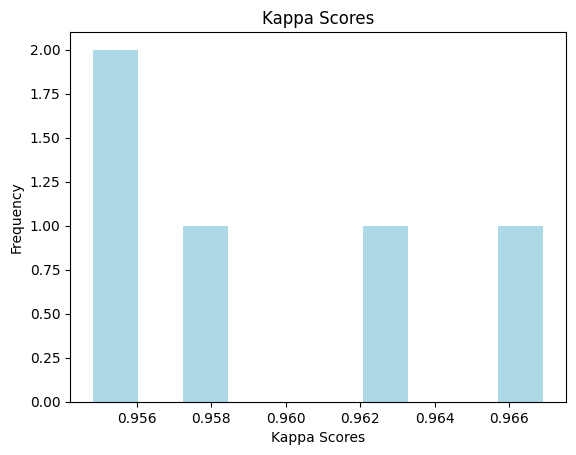

In [9]:
plt.hist(results, bins=10, color='lightblue')
plt.title('Kappa Scores')
plt.xlabel('Kappa Scores')
plt.ylabel('Frequency')
plt.show()

In [10]:
import matplotlib.pyplot as plt

def plot_keras_history_tf(history):
    """
    Plots the training and validation loss of a Keras history object.
    """
    if 'loss' not in history.history or 'val_loss' not in history.history:
        print('Error: missing keys in history object')
        return
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(epochs, loss, 'bo-', label='Training loss')
    ax1.plot(epochs, val_loss, 'ro-', label='Validation loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        ax2.plot(epochs, acc, 'bo-', label='Training acc')
        ax2.plot(epochs, val_acc, 'ro-', label='Validation acc')
        ax2.set_title('Training and validation accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
    
    plt.tight_layout()
    plt.show()


<AxesSubplot:ylabel='Count'>

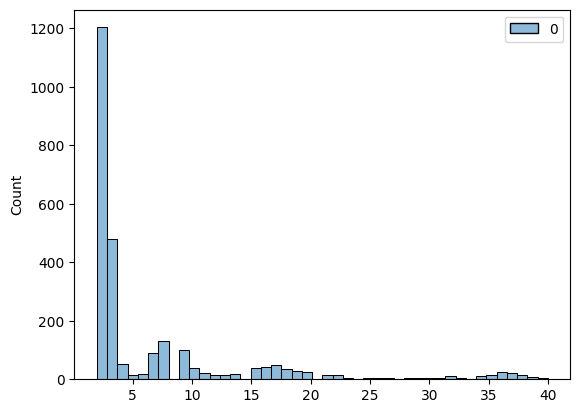

In [11]:
import seaborn as sns

sns.histplot(y_pred)

Text(0.5, 1.0, 'True and Predicted Value Counts')

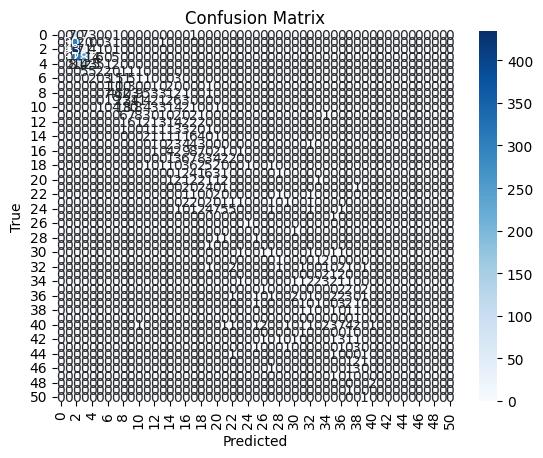

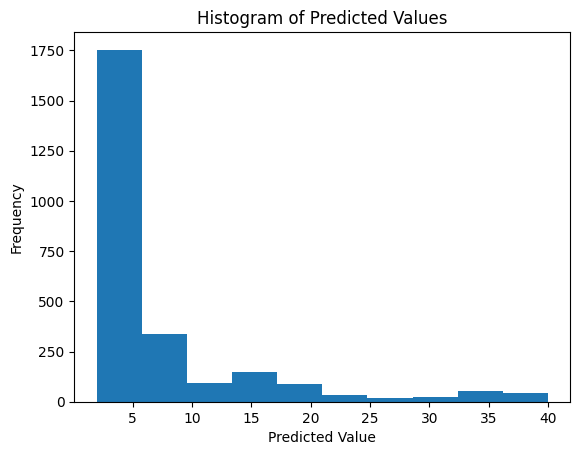

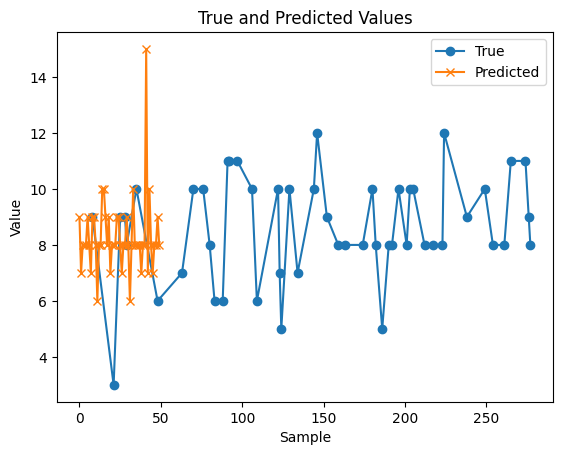

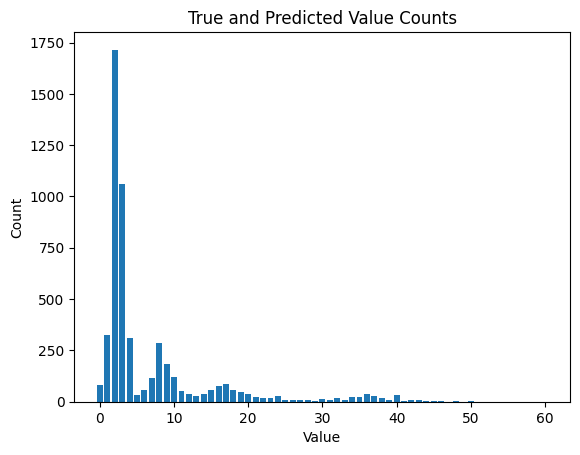

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred_rounded = y_pred.astype(int)
cm = confusion_matrix(y_test, y_pred_rounded)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Create a histogram of the predicted values
plt.figure()
plt.hist(y_pred, bins=10)
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Values')

# Create a line graph of the true and predicted values
plt.figure()
plt.plot(y_test[:50], 'o-', label='True')
plt.plot(y_pred[:50], 'x-', label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('True and Predicted Values')
plt.legend()

# Create a bar chart of the number of true and predicted values
y_test_arr = y_test.values.reshape(-1)
y_pred_arr = y_pred_rounded.reshape(-1)
unique, counts = np.unique(np.concatenate((y_test_arr, y_pred_arr)), return_counts=True)
plt.figure()
plt.bar(unique, counts)
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('True and Predicted Value Counts')

The Avg. Kappa Score is 0.961 which is the highest we have ever seen on this dataset.

In [13]:
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
import datetime

# Create a TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model with the TensorBoard callback
lstm_model = get_model()
lstm_model.fit(trainDataVecs, y_train, batch_size=64, epochs=50, callbacks=[tensorboard_callback])

# Save the final model
if count == 5:
    lstm_model.save('./model_weights/final_lstm.h5')

# Load the final model
loaded_model = load_model('./model_weights/final_lstm.h5')

# Use the TensorBoard callback to visualize the data
%load_ext tensorboard
%tensorboard --logdir logs/fit


Epoch 1/50
163/163 [==============================] - 8s 26ms/step - loss: 66.2117 - mae: 4.4506
Epoch 2/50
163/163 [==============================] - 3s 21ms/step - loss: 39.6545 - mae: 3.6090
Epoch 3/50
163/163 [==============================] - 3s 21ms/step - loss: 32.9254 - mae: 3.4585
Epoch 4/50
163/163 [==============================] - 4s 24ms/step - loss: 29.8419 - mae: 3.3822
Epoch 5/50
163/163 [==============================] - 3s 21ms/step - loss: 27.7009 - mae: 3.1568
Epoch 6/50
163/163 [==============================] - 4s 24ms/step - loss: 25.4744 - mae: 2.9687
Epoch 7/50
163/163 [==============================] - 4s 23ms/step - loss: 23.3287 - mae: 2.7836
Epoch 8/50
163/163 [==============================] - 4s 23ms/step - loss: 20.5824 - mae: 2.6074
Epoch 9/50
163/163 [==============================] - 3s 21ms/step - loss: 18.0982 - mae: 2.4387
Epoch 10/50
163/163 [==============================] - 4s 22ms/step - loss: 17.1285 - mae: 2.3483
Epoch 11/50
163/163 [========

In [14]:
tensorboard dev export --logdir /path/to/logs --format csv --outfile /path/to/output/file.csv


ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
usage: tensorboard [-h] [--helpfull] {serve,dev} ...
tensorboard: error: unrecognized arguments: --logdir /path/to/logs --format csv --outfile /path/to/output/file.csv